# Analiza slik z nevronskimi mrežami

## 1. Priprava podatkov za učenje nevronskih mrež

**Gradivo** za vajo je že naloženo na drive, in sicer v mapi `data_`. Ta vsebuje skupno 647 podmap, po eno za vsakega bolnika. Gre za slike bolnikov z multiplo sklerozo, pri katerih je bila iz sicer originalne 3D slike izločena ena sama 2D rezina v aksialni osi. Anatomska lokacija rezin med bolniki je enaka. V vsaki mapi je dana MRI preiskava glave in pridruženi podatki:
- **t1w.nii.gz**: 2D rezina T1-utežene MR slike
- **flair.nii.gz**: 2D rezina FLAIR MR slike
- **brainmask.nii.gz**: 2D rezina maske možganovine v T1 in FLAIR sliki
- **seg.nii.gz**: 2D rezina razgradnje možganovine v T1 in FLAIR sliki

Razgradnja vsebuje štiri oznake, in sicer:
- **CSF=1**: likvorska tekočina
- **GM=2**: siva možganovina
- **WM=3**: bela možganovina
- **LESIONS=10**: patološke lezije

Slike so že medsebojno poravnave in obdelane s postopki obnove šuma in sivinskih nehomogenosti. V naslednjih blokih bomo dane slike naložili in si jih prikazali. Kasneje bomo velikost slik in sivinske vrednosti ustrezno prilagodili, da bo možna neposredna uporaba te zbirke za učenje in vrednotenje modelov nevronskih mrež.

### Uvoz knjižnic za nalaganje, shranjevanje, osnovno manipulacijo in prikazovanje slik

In [11]:
#from google.colab import drive
#drive.mount('/content/drive/')
import os
import numpy as np
import matplotlib.pyplot as plt
#!pip install SimpleITK
import SimpleITK as itk
from amslib import resample_image

### Prikaži slike dane za posamezno MRI preiskavo bolnika

In [3]:
# prompt: unzip to conent
!unzip -q /Users/adisskrijelj/Desktop/FE/Biomedicinska_Tehnika/Analiza medicinskih slik/Vaje/Vaja1/Analiza_slik_z_nevronskimi_mrezami/data_


replace /content/data_/18a36c20dcedc784c776bb6fd6c9eac135e1550c99f7a60d970351d8/brainmask.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

V mapi data_/ je 648 podmap.
Velikost posamezne slike je (193, 229, 1)


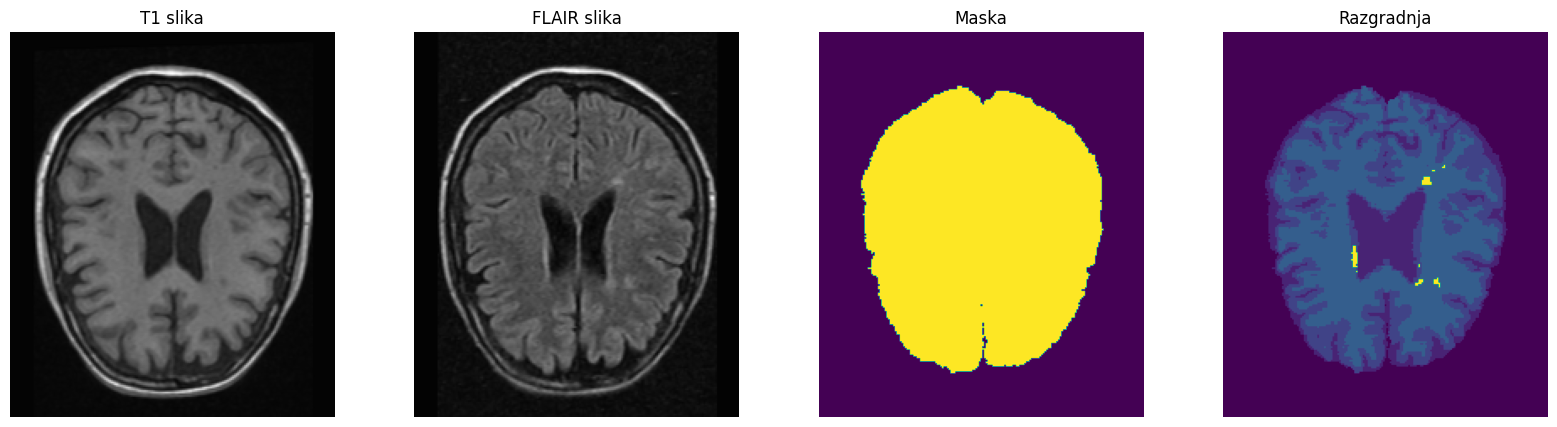

In [5]:
from os.path import join

DATA_PATH = 'data_/'
pacient_no = 0


# poišči vse podmape
patient_paths = os.listdir(DATA_PATH)
print('V mapi {:s} je {:d} podmap.'.format(DATA_PATH, len(patient_paths)))

# naloži podatke iz ene mape
patient_path = join(DATA_PATH, patient_paths[pacient_no])
t1 = itk.ReadImage(join(patient_path, 't1w.nii.gz'))
flair = itk.ReadImage(join(patient_path, 'flair.nii.gz'))
bmsk = itk.ReadImage(join(patient_path, 'brainmask.nii.gz'))
seg = itk.ReadImage(join(patient_path, 'seg.nii.gz'))

print('Velikost posamezne slike je {}'.format(t1.GetSize()))

def img2array(img):
    return np.squeeze(itk.GetArrayFromImage(img))

# prikaži podatke
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,5))
ax1.imshow(img2array(t1), cmap='gray')
ax1.set_title('T1 slika')
ax1.axis('off')

ax2.imshow(img2array(flair), cmap='gray')
ax2.set_title('FLAIR slika')
ax2.axis('off')

ax3.imshow(img2array(bmsk))
ax3.set_title('Maska')
ax3.axis('off')

ax4.imshow(img2array(seg))
ax4.set_title('Razgradnja')
ax4.axis('off')

plt.show()

### Priprava slik željene velikosti

Uporabili bomo funkcije v knjižnice **SimpleITK** za obrezovanje in interpolacijo slik tako, da bomo na izhodu dobili slike željene velikosti. Naš cilj bo, da bo velikost slik večkratno deljiva s faktorjem 2 (npr. 128x128, 64x64, ipd.).

Originalna velikost:  (193, 229, 1)
Originalni korak vzorčenja:  (193, 229, 1)
Velikost po obrezovanju:  (192, 192, 1)
Velikost po vzorčenju:  (128, 128, 1)
Korak vzorčenja:  (1.5, 1.5, 1.0)


(-0.5, 127.5, 127.5, -0.5)

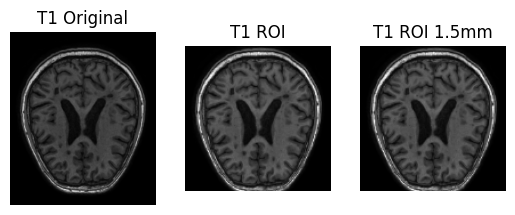

In [6]:
print('Originalna velikost: ', t1.GetSize())
print('Originalni korak vzorčenja: ', t1.GetSize())
t1_roi = itk.RegionOfInterest(t1, (192, 192, 1), (0, 18, 0))
print('Velikost po obrezovanju: ', t1_roi.GetSize())
t1_out = resample_image(t1_roi, (1.5, 1.5, 1.0))
print('Velikost po vzorčenju: ', t1_out.GetSize())
print('Korak vzorčenja: ', t1_out.GetSpacing())

f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img2array(t1), cmap='gray')
ax1.set_title('T1 Original')
ax1.axis('off')
ax2.imshow(img2array(t1_out), cmap='gray')
ax2.set_title('T1 ROI')
ax2.axis('off')
ax3.imshow(img2array(t1_out), cmap='gray')
ax3.set_title('T1 ROI 1.5mm')
ax3.axis('off')

Definiramo novo funkcijo **extract_image()**, ki implementira obrezovanje in interpolacijo.

Velikost po vzorčenju:  (64, 64, 1)
Korak vzorčenja:  (3.0, 3.0, 1.0)


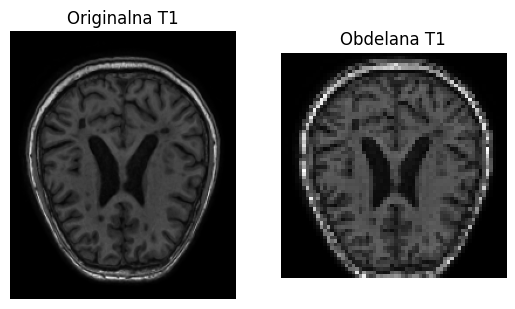

In [7]:
def extract_image(image, output_size=(128, 128), interpolation_type=itk.sitkLinear):
    new_spacing_mm = (192 / output_size[0], 192 / output_size[1], 1)
    return resample_image(
        itk.RegionOfInterest(image, (192, 192, 1), (0, 18, 0)),
        spacing_mm = new_spacing_mm,
        inter_type=interpolation_type)

t1_out = extract_image(t1, (64, 64), itk.sitkLinear)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img2array(t1), cmap='gray')
ax1.set_title('Originalna T1')
ax1.axis('off')
ax2.imshow(img2array(t1_out), cmap='gray')
ax2.set_title('Obdelana T1')
ax2.axis('off')

print('Velikost po vzorčenju: ', t1_out.GetSize())
print('Korak vzorčenja: ', t1_out.GetSpacing())

### Oblikovanje zbirke slik v večdimenzionalno polje

Najprej bomo vse dane 2D slike naložili in jih na enak način obrezali in vzorčili.

In [8]:
from tqdm import tqdm
# naloži vse podatke in obreži slike na velikost deljivo z 2
mri_data = []
OUTPUT_SIZE = (64, 64)

patient_paths = os.listdir(DATA_PATH)
for pacient_no in tqdm(range(len(patient_paths))):
    patient_path = join(DATA_PATH, patient_paths[pacient_no])

    # preberi slike
    t1 = itk.ReadImage(join(patient_path, 't1w.nii.gz'))
    flair = itk.ReadImage(join(patient_path, 'flair.nii.gz'))
    bmsk = itk.ReadImage(join(patient_path, 'brainmask.nii.gz'))
    seg = itk.ReadImage(join(patient_path, 'seg.nii.gz'))

    # obrezi in prevzorci slike
    t1 = extract_image(t1, OUTPUT_SIZE, itk.sitkLinear)
    flair = extract_image(flair, OUTPUT_SIZE, itk.sitkLinear)
    bmsk = extract_image(bmsk, OUTPUT_SIZE, itk.sitkNearestNeighbor)
    seg = extract_image(seg, OUTPUT_SIZE, itk.sitkNearestNeighbor)

    mri_data.append({'t1':t1, 'flair':flair, 'bmsk':bmsk, 'seg':seg})

100%|██████████| 647/647 [00:23<00:00, 27.62it/s]


 Slike nato zložimo v 3D sklad slik v obliki polja **numpy.ndarray**.

In [9]:
# zloži slike in maske v 3d polje
t1_array = np.dstack([np.squeeze(itk.GetArrayFromImage(data['t1'])) for data in mri_data])
flair_array = np.dstack([np.squeeze(itk.GetArrayFromImage(data['flair'])) for data in mri_data])
bmsk_array = np.dstack([np.squeeze(itk.GetArrayFromImage(data['bmsk'])) for data in mri_data])
seg_array = np.dstack([np.squeeze(itk.GetArrayFromImage(data['seg'])) for data in mri_data])
print('Velikost polja: {}'.format(t1_array.shape))

# preoblikuj polje tako, da je število vzorcev v prvi dimenziji
t1_array = np.transpose(t1_array, (2, 0, 1))
flair_array = np.transpose(flair_array, (2, 0, 1))
bmsk_array = np.transpose(bmsk_array, (2, 0, 1))
seg_array = np.transpose(seg_array, (2, 0, 1))
print('Velikost preoblikovanega polja: {}'.format(t1_array.shape))

Velikost polja: (64, 64, 647)
Velikost preoblikovanega polja: (647, 64, 64)


V zadnjem koraku slike oblikujemo v **4D numpy.array** polje, tako, da ena od dimenzij predstavlja število vhodnih slik. Če bomo uporabili le eno modaliteto (npr. T1-uteženo sliko), potem bo velikost v tej dimenziji enaka ena. Pri tem je potrebno glede na naše nameščene knjižnice preveriti, kakšno obliko 4D polja pričakuje knjižnica **Keras**. Poizvedbo lahko naredimo s klicem funkcije **keras.backend.image_data_format()**, ki vrne eno od dveh možnosti:
- **channels_first**: polje ima dimenzije (št.vzorcev, št. vhodnih slik, višina slike, širina slike)
- **channels_last**: polje ima dimenzije (št.vzorcev, višina slike, širina slike, št. vhodnih slik)

Glede na vrnjeno vrednost moram ustrezno oblikovati polje. V spodnjem bloku je prikazan postopek:

In [10]:
MODALITIES = ['t1', 'flair']

from keras import backend as K
print('Keras data format: {}'.format(K.image_data_format()))

# ustvari podatke za učenje in test
if K.image_data_format() == 'channels_first':
    t1_karray = t1_array[:, np.newaxis, :, :]
    flair_karray = flair_array[:, np.newaxis, :, :]
    bmsk_karray = bmsk_array[:, np.newaxis, :, :]
    seg_karray = seg_array[:, np.newaxis, :, :]
    channel_axis = 1
else:
    t1_karray = t1_array[:, :, :, np.newaxis]
    flair_karray = flair_array[:, :, :, np.newaxis]
    bmsk_karray = bmsk_array[:, :, :, np.newaxis]
    seg_karray = seg_array[:, :, :, np.newaxis]
    channel_axis = -1
print('Velikost polja T1 slik {}'.format(t1_karray.shape))

if 'flair' in MODALITIES and 't1' in MODALITIES:
    data = np.concatenate((t1_karray,flair_karray),axis=channel_axis)
elif 't1' in modalities:
    data = t1_karray
elif 'flair' in modalities:
    data = flair_karray
else:
    raise ValueError('Sivinske modalitete "{}" niso znane!'.format(MODALITIES))

print('Velikost polja sivinskih slik {}'.format(data.shape))

Keras data format: channels_last
Velikost polja T1 slik (647, 64, 64, 1)
Velikost polja sivinskih slik (647, 64, 64, 2)


### Normalizacija intenzitet slik

Dane MR preiskave so iz vsaj 9 različnih MR naprav, pri čemer so nastavitve posameznega zajema za posamezno napravo tudi različne. To pomeni, da je razpon intenzitet in kontrastov med tkivi lahko precej različen med preiskavami. Modeli strojnega učenja so v splošnem zelo občutljivi na tovrstne variacije vhodnih podatkov, zato je smiselno omejiti razpon vrednosti.

V nadaljevanju bomo razpon sivinskih vrednosti MR slik omejili na območje [0, 1]. To bomo naredili ločeno za T1-utežene in FLAIR slike tako, da bomo določili minimalno in maksimalno vrednost na množici vseh vhodnih slik $\{I_i^m; i=1,...,N; m=T1,FLAIR\}$, in sicer:

$I_{\max}^{m} = \max_{i} I_i^m$,

$I_{\min}^{m} = \min_{i} I_i^m$.

Nato normaliziramo sivinske vrednosti po enačbi:

$\tilde{I}_i^m = \frac{I_i^m - I_{\min}^{m}}{I_{\max}^{m} - I_{\min}^{m}}$.

Opisano operacijo naredimo s spodnjim blokom kode.

In [11]:
# Preberi velikosti slik
_, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = data.shape

# Izračunaj mejne sivinske vrednosti preko vseh slik (min, max)
def stat_per_channel(values, stat_fcn):
    return stat_fcn(
        np.reshape(
            values,
            (values.shape[0]*IMG_HEIGHT*IMG_WIDTH, IMG_CHANNELS)),
        axis=0)[:, np.newaxis]

min_data, max_data = stat_per_channel(data, np.min), stat_per_channel(data, np.max)
print('Območje sivinskih vrednosti pred normalizacijo:')
print('\tmin: {}'.format(min_data.flatten()))
print('\tmax:{}'.format(max_data.flatten()))

min_data = np.reshape(min_data, (1, 1, 1, IMG_CHANNELS))
max_data = np.reshape(max_data, (1, 1, 1, IMG_CHANNELS))

# Normaliziraj vhodne slike
X = (data - min_data) / (max_data - min_data)

min_data, max_data = stat_per_channel(X, np.min), stat_per_channel(X, np.max)
print('Območje sivinskih vrednosti po normalizaciji:')
print('\tmin: {}'.format(min_data.flatten()))
print('\tmax:{}'.format(max_data.flatten()))

Območje sivinskih vrednosti pred normalizacijo:
	min: [-254.30311584 -127.29030609]
	max:[10145.67480469  3496.00512695]
Območje sivinskih vrednosti po normalizaciji:
	min: [0. 0.]
	max:[1. 1.]


### Vse predhodne združimo bloke v eno "all in one wonder" funkcijo

Funkcijo z imenom **load_mri_brain_data()**, ki je že dana v pridruženi Python datoteki **amslib.py**, bomo podali parametre:
- **output_size**: željena izhodna velikost 2D slike
- **modalities**: seznam modalitet v izhodnem polju slikovnih podatkov **X**

Izhodi funkcije so:
- **X**: slikovno 4D polje sivinskih vrednosti slik izbranih modalitet
- **Y_bmsk**: 4D polje referenčne binarne maske možganovine
- **Y_seg**: 4D polje referenčne razgradnje možganovine v štiri strukture

Primer uporabe funkcije:

In [ ]:
from amslib import load_mri_brain_data

X, Y_bmsk, Y_seg = load_mri_brain_data(output_size=(64, 64), modalities=('t1','flair'), data_path = '/content/data_')
print('Velikost polja z modalitetami: {}'.format(X.shape))
print('Velikost polja z maskami: {}'.format(Y_bmsk.shape))

 20%|██        | 130/647 [00:05<00:17, 29.53it/s]